In [1]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x103876a18>>

In [2]:
# extract data

i = -1

data_num = 2000 - 605 # 1395

wifi_loc_time = np.zeros(shape = (data_num, 524))

# 520 WAP
# FLOOR 2
# Building 1
# timestamp

# total data num = 19938

with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if (row[523] == 'BUILDINGID'):
            continue
        elif (row[523] is not '1' or row[522] is not '2'):
            continue
        i = i+1
        if (i > data_num):
            break
        # wifi
        wifi_loc_time[i-1][:520] = np.array(row[:520])
        # location x, y
        wifi_loc_time[i-1][520:522] = np.array(row[520:522])
        # userID
        wifi_loc_time[i-1][522] = np.array(row[526])
        # time stamp
        wifi_loc_time[i-1][-1] = np.array(row[-1])

In [3]:
# sort by timestamp
# https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]

# Create 2-D coordinates
# [ 0,  0,  0,  0,  0,  0,  0,  0,  0]
# https://stackoverflow.com/questions/25924244/creating-2d-dictionary-in-python

longitude_list = sorted(np.unique(wifi_loc_time[:, 520:521]))
latitude_list = sorted(np.unique(wifi_loc_time[:, 521:522]))

long_dict = {}
loc_dict = {}
for i in range(len(longitude_list)):
    long_dict[float(longitude_list[i])] = i
for i in range(len(latitude_list)):
    loc_dict[float(latitude_list[i])] = long_dict.copy()
    
# Initialize loc_dict
for i in range(len(latitude_list)):
    for j in range(len(longitude_list)):
        loc_dict[float(latitude_list[i])][float(longitude_list[j])] = 0

add_up = 0
        
# Refine loc_dict
# for i in range(len(latitude_list)):
#     for j in range(len(longitude_list)):
#         loc_dict[latitude_list[i]][longitude_list[j]]=i*len(longitude_list)+j

# create exist points as states
#for i in range(len(wifi_loc_time[:,520:521])):
    #print(i, float(wifi_loc_time[i,521:522]), float(wifi_loc_time[i,520:521]), loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])])
    #loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])] = loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])] + 1

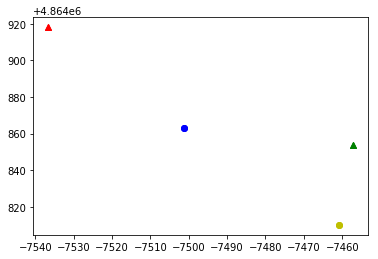

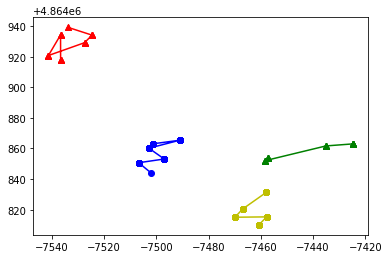

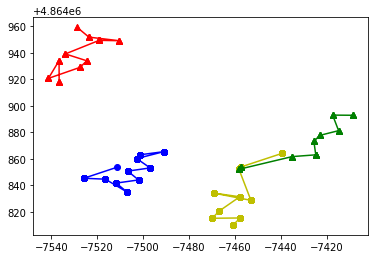

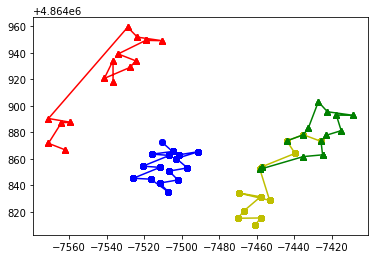

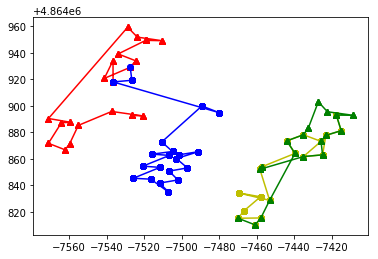

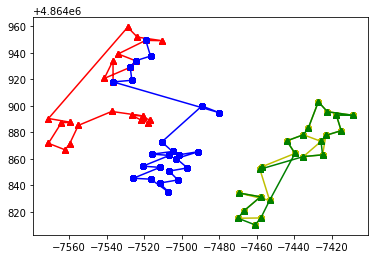

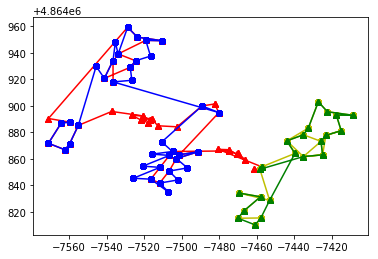

In [4]:
# partition data by users: array([ 2.,  4.,  9., 10.])
#                                471   374   316  234
np.unique(wifi_loc_time[:, 522])

user2 = 0
user4 = 0
user9 = 0
user10 = 0

# footprint: long, lat
user2_fp = np.zeros((471,2+520))
user4_fp = np.zeros((374,2+520))
user9_fp = np.zeros((316,2+520))
user10_fp = np.zeros((234,2+520))

for i in range(len(wifi_loc_time[:,522])):
    #print(wifi_loc_time[i,522])
    if (wifi_loc_time[i, 522] == 2):
        user2_fp[user2, :2] = np.array(wifi_loc_time[i, 520:522])
        user2_fp[user2, 2:] = np.array(wifi_loc_time[i, :520])
        user2 = user2+1
    elif (wifi_loc_time[i, 522] == 4):
        user4_fp[user4, :2] = np.array(wifi_loc_time[i, 520:522])
        user4_fp[user4, 2:] = np.array(wifi_loc_time[i, :520])
        user4 = user4+1
    elif (wifi_loc_time[i, 522] == 9):
        user9_fp[user9, :2] = np.array(wifi_loc_time[i, 520:522])
        user9_fp[user9, 2:] = np.array(wifi_loc_time[i, :520])
        user9 = user9+1
    elif (wifi_loc_time[i, 522] == 10):
        user10_fp[user10, :2] = np.array(wifi_loc_time[i, 520:522])
        user10_fp[user10, 2:] = np.array(wifi_loc_time[i, :520])
        user10 = user10+1
        
plt.plot(user2_fp[:2,0], user2_fp[:2,1], 'r^-',user4_fp[:2,0], user4_fp[:2,1], 'bo-', \
         user9_fp[:2,0], user9_fp[:2,1], 'yo-',user10_fp[:2,0], user10_fp[:2,1], 'g^-')

plt.show()

plt.plot(user2_fp[:50,0], user2_fp[:50,1], 'r^-',user4_fp[:50,0], user4_fp[:50,1], 'bo-', \
         user9_fp[:50,0], user9_fp[:50,1], 'yo-',user10_fp[:50,0], user10_fp[:50,1], 'g^-')
plt.show()

plt.plot(user2_fp[:100,0], user2_fp[:100,1], 'r^-',user4_fp[:100,0], user4_fp[:100,1], 'bo-', \
         user9_fp[:100,0], user9_fp[:100,1], 'yo-',user10_fp[:100,0], user10_fp[:100,1], 'g^-')
plt.show()

plt.plot(user2_fp[:150,0], user2_fp[:150,1], 'r^-',user4_fp[:150,0], user4_fp[:150,1], 'bo-', \
         user9_fp[:150,0], user9_fp[:150,1], 'yo-',user10_fp[:150,0], user10_fp[:150,1], 'g^-')
plt.show()

plt.plot(user2_fp[:200,0], user2_fp[:200,1], 'r^-',user4_fp[:200,0], user4_fp[:200,1], 'bo-', \
         user9_fp[:200,0], user9_fp[:200,1], 'yo-',user10_fp[:200,0], user10_fp[:200,1], 'g^-')
plt.show()

plt.plot(user2_fp[:234,0], user2_fp[:234,1], 'r^-',user4_fp[:234,0], user4_fp[:234,1], 'bo-', \
         user9_fp[:234,0], user9_fp[:234,1], 'yo-',user10_fp[:234,0], user10_fp[:234,1], 'g^-')
plt.show()

plt.plot(user2_fp[:,0], user2_fp[:,1], 'r^-',user4_fp[:,0], user4_fp[:,1], 'bo-', \
         user9_fp[:,0], user9_fp[:,1], 'yo-',user10_fp[:,0], user10_fp[:,1], 'g^-')
plt.show()

In [5]:
# small container
batch_num = 5
seq_window = 9
batch_wifi = np.zeros((batch_num, seq_window, 520))
batch_loc = np.zeros((batch_num, seq_window), dtype = int)

# create model
iteration = 100
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=iteration)

In [6]:
state_count = 0

# find the start
for i in range(len(latitude_list)):
    for j in range(len(longitude_list)):
        if (user2_fp[0][0] == longitude_list[j] and user2_fp[0][1] == latitude_list[i]):
            print(i, j, loc_dict[latitude_list[i]][longitude_list[j]])
            if (loc_dict[latitude_list[i]][longitude_list[j]] == 0):
                loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                state_count = state_count + 1
                print("Start state location:", i, j, loc_dict[latitude_list[i]][longitude_list[j]])
                break

# state decision by user2        
for k in range(1,user2):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user2_fp[k][0] == longitude_list[j] and user2_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

65 11 0
Start state location: 65 11 0
1 65 11 0
2 65 11 0
3 65 11 0
4 65 11 0
5 65 11 0
6 65 11 0
7 65 11 0
8 65 11 0
9 71 10 1
10 71 10 1
11 71 10 1
12 71 10 1
13 71 10 1
14 71 10 1
15 71 10 1
16 71 10 1
17 71 10 1
18 71 10 1
19 67 8 2
20 67 8 2
21 67 8 2
22 67 8 2
23 67 8 2
24 67 8 2
25 67 8 2
26 67 8 2
27 67 8 2
28 68 15 3
29 68 15 3
30 68 15 3
31 68 15 3
32 68 15 3
33 68 15 3
34 68 15 3
35 68 15 3
36 68 15 3
37 68 15 3
38 70 19 4
39 70 19 4
40 70 19 4
41 70 19 4
42 70 19 4
43 70 19 4
44 70 19 4
45 70 19 4
46 70 19 4
47 70 19 4
48 73 13 5
49 73 13 5
50 73 13 5
51 73 13 5
52 73 13 5
53 73 13 5
54 73 13 5
55 73 13 5
56 73 13 5
57 73 13 5
58 76 25 6
59 76 25 6
60 76 25 6
61 76 25 6
62 76 25 6
63 76 25 6
64 76 25 6
65 76 25 6
66 76 25 6
67 76 25 6
68 76 25 6
69 76 25 6
70 76 25 6
71 76 25 6
72 76 25 6
73 76 25 6
74 76 25 6
75 76 25 6
76 76 25 6
77 76 25 6
78 75 36 7
79 75 36 7
80 75 36 7
81 75 36 7
82 75 36 7
83 75 36 7
84 75 36 7
85 75 36 7
86 75 36 7
87 75 36 7
88 77 20 8
89 77 20 8
9

In [7]:
# state decision by user4        
for k in range(user4):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user4_fp[k][0] == longitude_list[j] and user4_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 24 44 30
1 24 44 30
2 24 44 30
3 24 44 30
4 24 44 30
5 24 44 30
6 24 44 30
7 24 44 30
8 24 44 30
9 24 44 30
10 29 46 31
11 29 46 31
12 29 46 31
13 29 46 31
14 29 46 31
15 29 46 31
16 29 46 31
17 29 46 31
18 29 46 31
19 29 46 31
20 20 41 32
21 20 41 32
22 20 41 32
23 20 41 32
24 20 41 32
25 20 41 32
26 20 41 32
27 20 41 32
28 20 41 32
29 15 45 48
30 15 45 48
31 15 45 48
32 15 45 48
33 15 45 48
34 15 45 48
35 15 45 48
36 15 45 48
37 15 45 48
38 15 45 48
39 12 38 33
40 12 38 33
41 12 38 33
42 12 38 33
43 12 38 33
44 12 38 33
45 12 38 33
46 12 38 33
47 12 38 33
48 12 38 33
49 9 43 49
50 9 43 49
51 9 43 49
52 9 43 49
53 9 43 49
54 9 43 49
55 9 43 49
56 9 43 49
57 9 43 49
58 9 43 49
59 8 33 34
60 8 33 34
61 8 33 34
62 8 33 34
63 8 33 34
64 8 33 34
65 8 33 34
66 8 33 34
67 8 33 34
68 8 33 34
69 7 37 50
70 7 37 50
71 7 37 50
72 7 37 50
73 7 37 50
74 7 37 50
75 7 37 50
76 7 37 50
77 7 37 50
78 7 37 50
79 10 29 35
80 10 29 35
81 10 29 35
82 10 29 35
83 10 29 35
84 10 29 35
85 10 29 35
86 10 29

In [8]:
# state decision by user9        
for k in range(user9):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user9_fp[k][0] == longitude_list[j] and user9_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 0 60 59
1 0 60 59
2 0 60 59
3 0 60 59
4 0 60 59
5 0 60 59
6 0 60 59
7 0 60 59
8 0 60 59
9 0 60 59
10 2 63 60
11 2 63 60
12 2 63 60
13 2 63 60
14 2 63 60
15 2 63 60
16 2 63 60
17 2 63 60
18 2 63 60
19 2 63 60
20 1 54 61
21 1 54 61
22 1 54 61
23 1 54 61
24 1 54 61
25 1 54 61
26 1 54 61
27 1 54 61
28 1 54 61
29 1 54 61
30 3 57 62
31 3 57 62
32 3 57 62
33 3 57 62
34 3 57 62
35 3 57 62
36 3 57 62
37 3 57 62
38 3 57 62
39 3 57 62
40 5 62 63
41 5 62 63
42 5 62 63
43 5 62 63
44 5 62 63
45 5 62 63
46 5 62 63
47 5 62 63
48 5 62 63
49 5 62 63
50 6 56 64
51 6 56 64
52 6 56 64
53 6 56 64
54 6 56 64
55 6 56 64
56 6 56 64
57 6 56 64
58 6 56 64
59 6 56 64
60 4 65 65
61 4 65 65
62 4 65 65
63 4 65 65
64 4 65 65
65 4 65 65
66 4 65 65
67 4 65 65
68 4 65 65
69 4 65 65
70 14 61 46
71 14 61 46
72 14 61 46
73 14 61 46
74 14 61 46
75 14 61 46
76 14 61 46
77 14 61 46
78 14 61 46
79 14 61 46
80 17 64 45
81 17 64 45
82 17 64 45
83 17 64 45
84 17 64 45
85 17 64 45
86 17 64 45
87 17 64 45
88 17 64 45
89 17 64 45


In [9]:
# state decision by user10        
for k in range(user10):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user10_fp[k][0] == longitude_list[j] and user10_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 17 64 45
1 17 64 45
2 17 64 45
3 17 64 45
4 17 64 45
5 17 64 45
6 17 64 45
7 17 64 45
8 17 64 45
9 17 64 45
10 14 61 46
11 14 61 46
12 14 61 46
13 14 61 46
14 14 61 46
15 14 61 46
16 14 61 46
17 14 61 46
18 14 61 46
19 14 61 46
20 21 68 70
21 21 68 70
22 21 68 70
23 21 68 70
24 21 68 70
25 21 68 70
26 21 68 70
27 21 68 70
28 21 68 70
29 21 68 70
30 23 73 71
31 23 73 71
32 23 73 71
33 23 73 71
34 23 73 71
35 23 73 71
36 23 73 71
37 23 73 71
38 23 73 71
39 23 73 71
40 23 73 71
41 23 73 71
42 23 73 71
43 23 73 71
44 23 73 71
45 23 73 71
46 23 73 71
47 23 73 71
48 23 73 71
49 23 73 71
50 38 72 69
51 38 72 69
52 38 72 69
53 38 72 69
54 38 72 69
55 38 72 69
56 38 72 69
57 38 72 69
58 38 72 69
59 38 72 69
60 40 74 72
61 40 74 72
62 40 74 72
63 40 74 72
64 40 74 72
65 40 74 72
66 40 74 72
67 40 74 72
68 40 74 72
69 40 74 72
70 42 77 73
71 42 77 73
72 42 77 73
73 42 77 73
74 42 77 73
75 42 77 73
76 42 77 73
77 42 77 73
78 42 77 73
79 42 77 73
80 58 76 74
81 58 76 74
82 58 76 74
83 58 76 74
84

In [11]:
# NOT YET
# train by user2 dataset 471
iter_batch = 0
iter_window = 0
        
for i in range(user2):
    # collect 5*9 
    batch_wifi[iter_batch][iter_window] = user2_fp[i][2:]
    batch_loc_train[iter_batch,iter_window] = \ 
      loc_dict[float(user2_fp[i][1])][float(user2_fp[i][0])]
        
    
    if (iter_window == 8):
        iter_window = 0
        if (iter_batch < 4):
            iter_batch = iter_batch + 1
        else (iter_batch == 4):
            # train this batch!
            ssvm.fit(batch_wifi, batch_loc)
            iter_batch = 0
    else:
        iter_window = iter_window + 1
        
# REVERSE train by user2 dataset 471
iter_batch = 0
iter_window = 0
        
for i in range(user2, 0):
    # collect 5*9 
    batch_wifi[iter_batch][iter_window] = user2_fp[i][2:]
    batch_loc_train[iter_batch,iter_window] = \ 
      loc_dict[float(user2_fp[i][1])][float(user2_fp[i][0])]
    
    if (iter_window == 8):
        iter_window = 0
        if (iter_batch < 4):
            iter_batch = iter_batch + 1
        else (iter_batch == 4):
            # train this batch!
            ssvm.fit(batch_wifi, batch_loc)
            iter_batch = 0
    else:
        iter_window = iter_window + 1

[[65 65 65 ... 65 65 65]
 [71 71 71 ... 71 71 71]
 [71 67 67 ... 67 17 17]
 ...
 [36 36 36 ... 36 47 47]
 [47 47 47 ... 47 47 49]
 [49 49 49 ... 49 49 49]]


In [10]:
# Testing
# extract data

i = -1

data_num_v = 86 # 86 in validation dataset

wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))

# 520 WAP
# FLOOR 2
# Building 1
# timestamp

# total data num = 19938

with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
    spamreader_v = csv.reader(v_csvfile, delimiter=',')
    for row in spamreader_v:
        if (row[523] == 'BUILDINGID'):
            continue
        elif (row[523] is not '1' or row[522] is not '2'):
            continue
        i = i+1
        #if (i > data_num):
        #    break
        # wifi
        wifi_loc_time_v[i-1][:520] = np.array(row[:520])
        # location x, y
        wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
        # userID
        wifi_loc_time_v[i-1][522] = np.array(row[526])
        # time stamp
        wifi_loc_time_v[i-1][-1] = np.array(row[-1])

In [11]:
# sort by timestamp
wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]

longitude_list_v = sorted(np.unique(wifi_loc_time_v[:, 520:521]))
latitude_list_v = sorted(np.unique(wifi_loc_time_v[:, 521:522]))

long_dict_v = {}
loc_dict_v = {}
for i in range(len(longitude_list_v)):
    long_dict_v[float(longitude_list_v[i])] = i
for i in range(len(latitude_list_v)):
    loc_dict_v[float(latitude_list_v[i])] = long_dict_v.copy()
    
min_dis = 0
max_ind = -1
distance  = 0
cumulative_distance = 0

# find the nearest loc_dict_v
for i in range(len(latitude_list_v)):
    for j in range(len(longitude_list_v)):
        min_dis = sys.float_info.max
        max_ind = -1
        for x in range(len(latitude_list)):
            for y in range(len(longitude_list)):
                distance = math.sqrt(pow(latitude_list[x]-latitude_list_v[i],2) \
                                     +pow(longitude_list[y]-longitude_list_v[j], 2))
                if (min_dis > distance):
                    if (loc_dict[float(latitude_list[x])][float(longitude_list[y])] != 0 or \
                       (loc_dict[float(latitude_list[x])][float(longitude_list[y])] == 0\
                              and x == 65 and y == 11)):
                        min_dis = distance
                        max_ind = loc_dict[float(latitude_list[x])][float(longitude_list[y])]
        cumulative_distance = cumulative_distance + min_dis
        loc_dict_v[latitude_list_v[i]][longitude_list_v[j]] = max_ind
        print(i, j, min_dis, max_ind)
print(cumulative_distance/(len(latitude_list_v)*len(longitude_list_v)))

0 0 52.19750068590108 51
0 1 48.89374530426823 51
0 2 45.44541658042998 51
0 3 37.62495899685668 51
0 4 36.84423944954561 51
0 5 35.42663982646444 51
0 6 35.12366434953198 51
0 7 31.027673917692503 50
0 8 30.746296605003916 50
0 9 30.44558750499818 50
0 10 30.13719156393056 50
0 11 28.7733832313789 50
0 12 28.435337517863072 50
0 13 28.044569890463617 50
0 14 27.765068613388785 50
0 15 27.608194587976655 50
0 16 26.644568147464508 50
0 17 26.180128010183022 50
0 18 25.944918239471146 50
0 19 25.81997327484255 50
0 20 24.664146048063497 50
0 21 24.604596007978635 50
0 22 24.583431826800457 50
0 23 24.416214417899006 50
0 24 23.97835307635992 50
0 25 23.971857038016953 50
0 26 23.966400647891145 50
0 27 23.95948966132228 50
0 28 23.97785230745655 50
0 29 24.000489018132757 50
0 30 24.147046154257037 50
0 31 24.166623995795042 50
0 32 24.313863591046008 50
0 33 24.359358722193086 50
0 34 24.43972751061922 50
0 35 24.53508480112417 50
0 36 24.621408666979512 50
0 37 24.70664842024927 50
0 

4 2 33.69683335319655 51
4 3 22.041511503965104 51
4 4 20.68063515658388 51
4 5 18.034342218620456 51
4 6 17.431651878203155 51
4 7 15.87134375202823 51
4 8 15.851485516289978 51
4 9 15.844109123572707 51
4 10 15.852124207008051 51
4 11 16.098773246179395 51
4 12 16.16299839749399 34
4 13 15.55848437699804 50
4 14 15.048839519191525 50
4 15 14.757403029523083 50
4 16 12.864740476708956 50
4 17 11.872979339566085 50
4 18 11.34492477811273 50
4 19 11.056199875263518 50
4 20 7.993036722572948 50
4 21 7.807347852121857 50
4 22 7.74039121434693 50
4 23 7.191666167795391 50
4 24 5.525391571895404 50
4 25 5.497132490609666 50
4 26 5.473289302003921 50
4 27 5.442947785823661 50
4 28 5.523217997362863 50
4 29 5.620676905649764 50
4 30 6.21678162267368 50
4 31 6.292396294125973 50
4 32 6.836117208780592 50
4 33 6.99620562338458 50
4 34 7.271094591704295 50
4 35 7.585441448363296 50
4 36 7.860171786583762 50
4 37 8.123239004855103 50
4 38 8.124805931274357 50
4 39 8.394536449346745 50
4 40 14.695

8 3 15.751994245716874 51
8 4 13.783532341798479 51
8 5 9.355992336251008 51
8 6 8.133853978314038 51
8 7 3.7678436582104924 51
8 8 3.683298305978281 51
8 9 3.6514226347208023 51
8 10 3.6860460132887884 51
8 11 4.6333134331246155 51
8 12 5.037939067206249 51
8 13 5.572398766342629 51
8 14 5.455408293443296 35
8 15 5.194847769362634 35
8 16 3.6895020023226053 35
8 17 3.152378096220662 35
8 18 2.994361367232245 35
8 19 2.955684214648487 35
8 20 1.1521725745142248 34
8 21 0.896100003272295 34
8 22 0.8023792315580067 34
8 23 0.0 34
8 24 3.733357103031267 34
8 25 3.9097201302893154 34
8 26 4.096099998801947 34
8 27 4.902317017284076 34
8 28 4.724241179161928 49
8 29 4.335290394619176 49
8 30 3.1275344934448444 49
8 31 3.0303376159493776 49
8 32 2.5436049227015203 49
8 33 2.463890959054048 49
8 34 2.388975191119974 49
8 35 2.3920470238465925 49
8 36 2.4622871488783784 49
8 37 2.5782182846712027 49
8 38 2.5790315915692386 49
8 39 2.7374188933081065 49
8 40 8.934188910982119 49
8 41 10.2265137

11 72 19.45830310450106 71
11 73 19.48345896239898 71
11 74 19.521806167168748 71
11 75 19.545267699269207 71
11 76 20.02185721706061 71
11 77 20.046808321594476 71
11 78 20.69484131394924 71
12 0 22.064774928698817 14
12 1 21.927872180478527 14
12 2 22.852826624965314 14
12 3 15.327747129000077 51
12 4 13.296626382315072 51
12 5 8.62259252948092 51
12 6 7.278330156980216 51
12 7 1.0055621145357438 51
12 8 0.617410515212567 51
12 9 0.38392263650894165 51
12 10 0.6335965163688507 51
12 11 2.8778642607054246 51
12 12 3.492182609537414 51
12 13 4.2268353817731565 51
12 14 4.599976731055077 35
12 15 4.287744118406577 35
12 16 2.2384662836908604 35
12 17 1.1557655210335969 35
12 18 0.6037435512295083 35
12 19 0.3665725778075898 35
12 20 3.4646872701265905 34
12 21 3.3881486765162943 34
12 22 3.3645755556310704 34
12 23 3.2674999982118607 34
12 24 4.961301391476688 34
12 25 5.095337843117374 34
12 26 5.2397129156567175 34
12 27 4.923270796057103 49
12 28 4.176891107568862 49
12 29 3.73131443

15 63 16.700297740377934 70
15 64 16.745098508529626 70
15 65 16.754987374984037 70
15 66 17.351175057496974 70
15 67 18.048631830924197 71
15 68 17.90741647604518 71
15 69 17.906307773664594 71
15 70 17.911089371192556 71
15 71 17.92964986213217 71
15 72 17.990334611380728 71
15 73 18.01754014460057 71
15 74 18.05900040842005 71
15 75 18.084359794001667 71
15 76 18.598423216583978 71
15 77 18.62528130272285 71
15 78 19.32105164664564 71
16 0 21.684293993315322 14
16 1 21.54497369916703 14
16 2 22.485684292125036 14
16 3 15.322938212358167 51
16 4 13.291082595486841 51
16 5 8.614041173493206 51
16 6 7.268197388842964 51
16 7 0.9293861282403668 51
16 8 0.48352782078291057 51
16 9 0.0 51
16 10 0.5040317001248695 51
16 11 2.8521406192930954 51
16 12 3.471014662534799 51
16 13 4.2093634618295255 51
16 14 4.642302596052397 35
16 15 4.333120941307417 35
16 16 2.3242028246879505 35
16 17 1.3141466458035564 35
16 18 0.8693064722627425 35
16 19 0.7249571862304545 35
16 20 3.6535897098896477 35


19 57 10.248163230347965 70
19 58 10.21782647867559 70
19 59 10.20822126006543 70
19 60 10.21887734021485 70
19 61 10.221749176293498 70
19 62 10.241209264052411 70
19 63 10.394138498270568 70
19 64 10.465968400693704 70
19 65 10.48178288459709 70
19 66 11.410584839519103 70
19 67 11.748967803169801 71
19 68 11.530858524767575 71
19 69 11.529136635363102 71
19 70 11.536561703320345 71
19 71 11.565356788717189 71
19 72 11.659214077334454 71
19 73 11.701148932218736 71
19 74 11.764889681717637 71
19 75 11.803779167308011 71
19 76 12.577220663359633 71
19 77 12.616902832202046 71
19 78 13.62307491736057 71
20 0 13.253586967597384 14
20 1 13.024394543199902 14
20 2 14.527730710756407 14
20 3 17.551360079661084 51
20 4 15.808563557332713 51
20 5 12.1432907617668 51
20 6 11.228735390477343 51
20 7 6.022942380864763 52
20 8 5.579154182173435 52
20 9 5.098279686543337 52
20 10 4.597606331683715 52
20 11 2.2846925516876238 52
20 12 1.6913230750405208 52
20 13 1.023706262090288 52
20 14 0.639762

23 49 1.0487349099413468 42
23 50 5.784319771436674 42
23 51 6.598829848388844 45
23 52 6.973453673042254 45
23 53 7.972075713845398 45
23 54 3.7588876973632814 66
23 55 3.7688210781592715 66
23 56 1.9502144327338153 70
23 57 1.5730013050064215 70
23 58 1.3614189134942565 70
23 59 1.2873479732177135 70
23 60 1.369283609794693 70
23 61 1.390553750400426 70
23 62 1.5270398487953138 70
23 63 2.342562407050499 70
23 64 2.643100087778558 70
23 65 2.7050426890399284 70
23 66 5.258415149981891 70
23 67 3.4502634895859825 71
23 68 2.6128092210979466 71
23 69 2.605199659243226 71
23 70 2.637864598907042 71
23 71 2.761077934064185 71
23 72 3.1310296403520868 71
23 73 3.283741774502532 71
23 74 3.504098019553039 71
23 75 3.63253029419219 71
23 76 5.661497445242727 71
23 77 5.749113913019761 71
23 78 7.710657813161474 71
24 0 6.267220293118829 14
24 1 5.766743961001618 14
24 2 8.641495374011843 14
24 3 21.216831079671294 15
24 4 19.586408202960445 52
24 5 15.289634721405822 52
24 6 14.098133493525

27 44 5.168450269807282 44
27 45 4.918296055626625 44
27 46 2.250986685554743 40
27 47 1.8123851230586563 40
27 48 2.9903930720940606 42
27 49 2.9206071816592636 42
27 50 6.394408230357458 42
27 51 8.222666459274905 42
27 52 8.735719548179208 45
27 53 9.551844381147417 45
27 54 1.9513800026298334 66
27 55 1.9704465261590303 66
27 56 1.5815848074693437 70
27 57 1.0827775741704615 70
27 58 0.7426544469633544 70
27 59 0.5961031569471167 70
27 60 0.7569754115075 70
27 61 0.794804317003408 70
27 62 1.0148521416361 70
27 63 2.0458916883600637 70
27 64 2.384125047808857 70
27 65 2.452616993968469 70
27 66 5.133128096895073 70
27 67 2.377885402444575 71
27 68 0.7594688047862235 71
27 69 0.7328615859150887 71
27 70 0.8416355991496373 71
27 71 1.171994964820713 71
27 72 1.8850377843301374 71
27 73 2.12907982029843 71
27 74 2.4553459573397163 71
27 75 2.635393173287993 71
27 76 5.079623427192106 71
27 77 5.177096833599536 71
27 78 7.294125358893761 71
28 0 5.253461396151078 14
28 1 4.645012631857

31 37 0.23725907833811172 30
31 38 0.23924379211702868 30
31 39 0.5892554315354952 30
31 40 3.3543015473217555 31
31 41 2.600224916669119 31
31 42 2.393778022378683 31
31 43 3.2658583258449285 31
31 44 4.48436162723872 44
31 45 4.193597155566155 44
31 46 1.88331561313095 40
31 47 1.3284112595135664 40
31 48 3.0909209722513102 41
31 49 3.653416439281099 42
31 50 6.760618461776475 42
31 51 8.510566906483621 42
31 52 9.43704844559483 45
31 53 10.19719659620824 45
31 54 1.295067673473055 66
31 55 1.3236222560320954 66
31 56 1.9751120689363606 70
31 57 1.6037657113078267 70
31 58 1.3968510333012163 70
31 59 1.3247626788834854 70
31 60 1.404517338898733 70
31 61 1.4252617598067674 70
31 62 1.5587116638505047 70
31 63 2.363330273605664 70
31 64 2.66152389153842 70
31 65 2.7230474290293145 70
31 66 5.153773484847989 71
31 67 2.262134585529566 71
31 68 0.19926555480924438 71
31 69 3.725290298461914e-09 71
31 70 0.41384100527375267 71
31 71 0.9145961368030839 71
31 72 1.7367444671690464 71
31 73

35 29 1.4225947753553632 37
35 30 2.0713149785671203 38
35 31 2.1394429134733692 38
35 32 1.7647165462267256 30
35 33 1.5217681193734396 30
35 34 1.1390877823375956 30
35 35 0.7752355105331198 30
35 36 0.5880310051286745 30
35 37 0.6140379276244675 30
35 38 0.6148075295359 30
35 39 0.8172959500092871 30
35 40 2.924398345358697 31
35 41 2.0154246275260426 31
35 42 1.740959514863789 31
35 43 2.8225161499028135 31
35 44 3.8899792121071664 44
35 45 3.5508725927505953 44
35 46 1.7599525923572654 40
35 47 0.7434745696583579 41
35 48 2.8781059553259416 41
35 49 3.546462254596563 41
35 50 7.134556571308196 42
35 51 8.81054394196058 42
35 52 10.065562629296888 45
35 53 10.781488120918894 45
35 54 0.8269385237634149 66
35 55 0.8709781397214269 66
35 56 2.4601731739386916 70
35 57 2.173349676806796 70
35 58 2.0254819599651293 70
35 59 1.9764565556247509 70
35 60 2.0307765303392404 70
35 61 2.04517858508175 70
35 62 2.1403192313141313 70
35 63 2.78149498346672 70
35 64 3.0389297106282864 70
35 65 

39 13 5.975825691633655 53
39 14 5.439395542356162 53
39 15 5.132272201780628 53
39 16 3.1402846843563825 53
39 17 2.1264565458025873 53
39 18 1.6277646692013006 53
39 19 1.386253196981296 53
39 20 3.0107913031443974 53
39 21 3.2528256708873675 53
39 22 3.3419316306450617 53
39 23 4.1132058067751585 53
39 24 2.4708458538784783 37
39 25 2.369862826522159 37
39 26 2.2731617772916395 37
39 27 2.0063280895382074 37
39 28 1.550802408310166 38
39 29 1.2345179809948446 38
39 30 1.3127754572349213 38
39 31 1.4178327266265456 38
39 32 2.220678425590048 30
39 33 2.0329698449549336 30
39 34 1.764853862852529 30
39 35 1.555049284796549 30
39 36 1.470703452211679 30
39 37 1.4812936096250677 30
39 38 1.4816127968294377 30
39 39 1.576439295138349 30
39 40 2.4982697912795087 31
39 41 1.323322597449905 31
39 42 0.8486379086971283 31
39 43 2.3782017753221187 31
39 44 3.1156049531686523 44
39 45 2.680252249981424 44
39 46 1.9651616407774086 40
39 47 0.4417877202558592 41
39 48 2.815300311533894 41
39 49 

42 76 5.567374718891936 71
42 77 5.656449303489294 71
42 78 7.64181600470302 71
43 0 3.07636067574583 14
43 1 1.8550689250115513 14
43 2 6.697864368876318 14
43 3 19.449511882073462 15
43 4 21.404749792336645 15
43 5 17.81389304917989 52
43 6 16.802357681435033 52
43 7 11.265590208127438 53
43 8 10.829577317921954 53
43 9 10.357674255736184 53
43 10 9.866958583897176 53
43 11 7.603880455348501 53
43 12 7.016728298055899 53
43 13 6.324144239693812 53
43 14 5.819908206653062 53
43 15 5.533943044596118 53
43 16 3.761076384024504 53
43 17 2.9675116021424826 53
43 18 2.633234795069287 53
43 19 2.4911855799607614 53
43 20 3.653651863376355 53
43 21 3.8555391987175316 53
43 22 3.931006829244835 53
43 23 4.604646531119674 53
43 24 3.1357837491946983 38
43 25 2.9602454356529164 38
43 26 2.7748507919864984 38
43 27 1.9750328617668749 38
43 28 1.2276536323894378 38
43 29 0.7913153460523542 38
43 30 0.9085839161116196 38
43 31 1.0547013663552516 38
43 32 2.011725924476476 38
43 33 2.26852630557649

46 69 1.497518315504884 69
46 70 1.761251337200467 69
46 71 2.1447468944767087 69
46 72 2.8542764501452047 69
46 73 3.0923406885144433 69
46 74 3.4104405967358993 69
46 75 3.58613151000602 69
46 76 5.988876041295446 69
46 77 6.085241515860668 69
46 78 7.979276878115487 72
47 0 6.539064208124478 15
47 1 3.8802294340371497 15
47 2 5.67737060659482 15
47 3 17.247018929640042 16
47 4 18.93262858278963 16
47 5 19.043868258968367 20
47 6 18.18403697185419 20
47 7 14.998464898134287 21
47 8 14.740232515359978 21
47 9 14.47050523058529 21
47 10 14.201417032197117 21
47 11 12.593263301230717 54
47 12 11.986848855063458 54
47 13 11.265138039344347 54
47 14 10.733617730529225 54
47 15 10.429113170186405 54
47 16 8.440687926239153 54
47 17 7.390795691231357 54
47 18 6.829778649313628 54
47 19 6.522597003996404 54
47 20 3.345479882484751 54
47 21 3.176902115483864 54
47 22 3.1181837937568933 54
47 23 2.697680495428473 54
47 24 3.5821806945539496 54
47 25 3.712673412739945 54
47 26 3.854548406749901

50 59 0.8640843057577358 68
50 60 0.9781057513319396 68
50 61 1.007090339489048 68
50 62 1.1859975750668699 68
50 63 2.130653814274396 68
50 64 2.4558189226103777 68
50 65 2.5220848824380635 68
50 66 5.161416451207822 68
50 67 4.045365156096312 72
50 68 2.0022575153965625 72
50 69 1.8072802619777568 72
50 70 1.4061919090302208 72
50 71 0.9358357832909584 72
50 72 0.3934552206905451 72
50 73 0.4573848421408104 72
50 74 0.6997295414030394 72
50 75 0.861861670204025 72
50 76 3.2858607499769237 72
50 77 3.3836603438136708 72
50 78 4.782603761538476 73
51 0 8.764401265998542 12
51 1 7.149805497603814 15
51 2 6.788440721453644 16
51 3 15.545306280134433 16
51 4 17.39658904606555 16
51 5 16.273750123383376 19
51 6 15.680021077469373 19
51 7 12.03465354628575 20
51 8 11.860851763567734 20
51 9 11.688679273691948 20
51 10 11.50672677580259 21
51 11 10.156726969160378 21
51 12 9.863428680402727 21
51 13 9.554259532827837 21
51 14 9.356836375611916 21
51 15 9.25611515756095 21
51 16 8.84459268195

54 50 18.019314675429523 67
54 51 16.181931585319 67
54 52 12.653326125609244 67
54 53 10.975572257051178 67
54 54 4.319338560190798 68
54 55 4.2744874632229175 68
54 56 2.5527995181839302 68
54 57 2.2752141740959866 68
54 58 2.132278146300499 68
54 59 2.0831358021550868 68
54 60 2.1329566201758783 68
54 61 2.146402579819465 68
54 62 2.235934554236323 68
54 63 2.8517536287424132 68
54 64 2.923483833777876 78
54 65 2.9167722943845957 78
54 66 3.818359081831123 78
54 67 4.765220138132126 72
54 68 3.2173558828118223 72
54 69 3.099775098944473 72
54 70 2.8843923803331406 72
54 71 2.6866582090004725 72
54 72 2.5489509076069847 72
54 73 2.5595985256524116 72
54 74 2.6138028138736735 72
54 75 2.661794367953448 72
54 76 4.139954660010268 72
54 77 4.2179972784485145 72
54 78 2.8686478615586872 73
55 0 5.955356733186064 12
55 1 6.437362859348475 11
55 2 3.966255130801108 16
55 3 14.536326897710547 16
55 4 14.584994128953761 17
55 5 13.846387636599818 19
55 6 13.14346105462894 19
55 7 9.515761968

58 38 1.4571213156392668 26
58 39 1.8147991484094639 26
58 40 9.070010067180066 26
58 41 10.40426156299178 26
58 42 11.41959032540096 26
58 43 13.6411388864502 26
58 44 11.052633087514879 29
58 45 10.870171814462688 29
58 46 13.400645671430249 29
58 47 15.285039566532623 29
58 48 17.087687600977876 29
58 49 17.619822568114976 29
58 50 19.75572412434968 67
58 51 18.095520001845948 67
58 52 15.023301779112591 67
58 53 13.640239025582126 67
58 54 6.461245596347581 78
58 55 6.410484198090382 78
58 56 4.189489891219102 78
58 57 3.6454628667682667 78
58 58 3.2057366820153406 78
58 59 2.6843757960877497 78
58 60 2.3288874640577544 78
58 61 2.2754325515397724 78
58 62 2.0101726814938305 78
58 63 1.1199725690217313 78
58 64 0.9547854333647273 78
58 65 0.9340332513858716 78
58 66 2.6352843442799676 78
58 67 5.442992692706114 78
58 68 6.653852454949519 72
58 69 6.597801094274525 72
58 70 6.4993917422554075 72
58 71 6.4140865247955245 72
58 72 6.357635122037468 72
58 73 6.3619115231269845 72
58 74

62 28 4.0714918829376545 26
62 29 3.670428179391568 26
62 30 2.4327730329834005 26
62 31 2.336693722699463 26
62 32 1.9083795868901923 26
62 33 1.8655123534796685 26
62 34 1.8723867749883563 26
62 35 1.9857926827124004 26
62 36 2.153787192554855 26
62 37 2.356266060377393 26
62 38 2.357565627875383 26
62 39 2.593917714638777 26
62 40 9.25742922090128 26
62 41 10.568044844359683 26
62 42 11.569008443304048 26
62 43 12.433844158310743 29
62 44 9.12736805826118 29
62 45 8.90554797750688 29
62 46 11.862775978452937 29
62 47 13.956381481394294 29
62 48 15.910286516978594 29
62 49 16.480482299847647 29
62 50 20.86862406956954 67
62 51 19.30436942810648 67
62 52 16.459356950558334 67
62 53 15.207463810728564 67
62 54 7.011407303262742 78
62 55 6.964656873808759 78
62 56 4.996395026872092 78
62 57 4.549894199749202 78
62 58 4.205815662905811 78
62 59 3.8233507726269194 78
62 60 3.582716083667596 78
62 61 3.548201095277989 78
62 62 3.3842180670502335 78
62 63 2.9438879515508494 78
62 64 2.88509

66 18 0.4125780086773127 22
66 19 0.42723383074299204 22
66 20 3.20626630645718 24
66 21 3.461870025985746 24
66 22 3.5554360679535284 24
66 23 4.356762847465086 24
66 24 6.5964701228877365 25
66 25 6.720665989724366 25
66 26 6.854402276224055 25
66 27 7.034336179802666 26
66 28 6.586850541559236 26
66 29 6.346778468174519 26
66 30 5.720833727178518 26
66 31 5.680641817410693 26
66 32 5.51828474724449 26
66 33 5.503607021308594 26
66 34 5.505940985804633 26
66 35 5.545532118987872 26
66 36 5.607883127778727 26
66 37 5.6887207394368025 26
66 38 5.689259142784009 26
66 39 5.7911970277593605 26
66 40 10.607051884666582 26
66 41 10.661360192802269 27
66 42 10.434094821287147 27
66 43 10.150423921562203 29
66 44 5.633779628742187 29
66 45 5.266821623516488 29
66 46 9.442249686871452 29
66 47 11.967088588644675 29
66 48 14.197459008097711 29
66 49 14.833641564695286 29
66 50 20.21623144411497 29
66 51 21.83804732746106 67
66 52 19.368842590240387 67
66 53 18.31689350338195 67
66 54 9.1291407

70 12 2.434989452408622 18
70 13 2.0194604306832034 18
70 14 1.8469484236718283 18
70 15 1.8157554162117786 18
70 16 2.7265582907986285 18
70 17 3.625979983556719 18
70 18 4.154226289574427 18
70 19 4.412598874672581 24
70 20 5.42096813503305 24
70 21 5.575956955531462 24
70 22 5.6345254925704245 24
70 23 6.171558506744729 24
70 24 9.193583444747201 24
70 25 9.349065827971751 24
70 26 9.514170652777496 24
70 27 10.236776559047602 24
70 28 10.70951054074802 26
70 29 10.56355114957264 26
70 30 10.199752668549225 26
70 31 10.177264240613429 26
70 32 10.087540954921817 26
70 33 10.079519145800113 26
70 34 10.080793723944414 26
70 35 10.102472095892168 26
70 36 10.136832303060908 26
70 37 10.181775857720115 26
70 38 10.182076682057803 26
70 39 10.239383720707151 26
70 40 7.074647453476138 27
70 41 6.3729945945091515 27
70 42 5.985047508632268 27
70 43 5.7028484553651335 27
70 44 2.143288075931555 29
70 45 0.7704679650321552 29
70 46 7.874661263852811 29
70 47 10.773366240858497 29
70 48 13.

74 5 2.9230205183659415 17
74 6 4.264040573445463 17
74 7 3.2823954576543537 19
74 8 3.3076097460028895 19
74 9 3.401450753917995 19
74 10 3.5670591435374788 19
74 11 4.2795646854126375 18
74 12 3.9903984517157967 18
74 13 3.7513099846866527 18
74 14 3.6613282630513257 18
74 15 3.645692513311702 18
74 16 4.174712718647515 18
74 17 4.810596325952591 18
74 18 5.22031629646192 18
74 19 5.461602969101305 18
74 20 6.98222665559819 24
74 21 7.103230921140172 24
74 22 7.149298642211567 24
74 23 7.57975777655694 24
74 24 10.19247615178137 24
74 25 10.332938856145976 24
74 26 10.482558693337937 24
74 27 11.14253956102327 24
74 28 11.78232029204291 24
74 29 12.173433521257094 24
74 30 12.011227253220211 26
74 31 11.992136300600981 26
74 32 11.916086108540332 26
74 33 11.909296026192058 26
74 34 11.910374794003756 26
74 35 11.92872868654505 26
74 36 11.957842396072211 26
74 37 11.995965373648554 26
74 38 11.996220704381365 26
74 39 12.044899526721073 26
74 40 5.707056787747659 27
74 41 4.80987740

77 78 8.852786471470885 76
78 0 24.47866175326774 10
78 1 20.423496867816088 2
78 2 15.734187527930182 2
78 3 5.998074669525443 0
78 4 4.652357731209501 0
78 5 4.475592610532597 0
78 6 5.260465532030047 0
78 7 5.1442558303476185 55
78 8 5.146827586232764 55
78 9 5.193064650931358 55
78 10 5.288103740562359 55
78 11 6.2691114958215355 55
78 12 6.642751520354762 55
78 13 7.133302001075812 55
78 14 7.521600527140284 55
78 15 7.753067106550358 55
78 16 9.395075715883792 55
78 17 10.337283132392793 55
78 18 10.85997952911782 55
78 19 11.152026022424625 55
78 20 14.600309132278726 55
78 21 14.840258261864932 55
78 22 14.928211886111926 55
78 23 15.683950831372414 55
78 24 19.250007966820377 55
78 25 19.420023298014108 55
78 26 19.59981686049487 55
78 27 20.378906919354492 55
78 28 21.116292893402804 55
78 29 21.560125843767544 55
78 30 20.581060870447285 27
78 31 20.470832295312867 27
78 32 19.781193484429153 27
78 33 19.602336642733174 27
78 34 19.313012059923402 27
78 35 19.00449838799689 

81 70 34.65161811767473 77
81 71 34.69388146190622 77
81 72 34.77879851991296 77
81 73 34.80992436558169 77
81 74 34.85376544770642 77
81 75 34.879108258576736 77
81 76 35.30860626454103 77
81 77 35.32906739804696 77
81 78 35.83562223914563 77
82 0 21.171527356357732 58
82 1 17.11201778229249 58
82 2 12.930166051872042 58
82 3 6.000931380106697 1
82 4 4.6660663837626455 1
82 5 1.2107885827049525 5
82 6 1.3544879398148977 5
82 7 4.624172671457682 4
82 8 4.431748178011679 4
82 9 4.266142102280515 4
82 10 4.146833184297037 4
82 11 4.383750881829672 4
82 12 4.646087931315061 4
82 13 5.023225312341688 56
82 14 4.481598552226736 56
82 15 4.171078690854176 56
82 16 2.145785399404374 56
82 17 1.1138666897791814 56
82 18 0.6617080316717354 56
82 19 0.5484521830949551 56
82 20 3.7664252199017505 56
82 21 4.019956613134995 56
82 22 4.112826040198193 56
82 23 4.909241149765245 56
82 24 8.629392008757382 56
82 25 8.805407692556031 56
82 26 8.991435283890512 56
82 27 9.796282724967352 56
82 28 10.55

In [14]:
batch_wifi_v = np.zeros((batch_num, seq_window, 520))
batch_loc_v = np.zeros((data_num, seq_window), dtype = int)

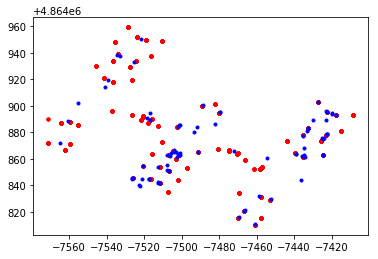

In [14]:
# # plot exist points both train and test
plt.plot(wifi_loc_time[:, 520:521], wifi_loc_time[:, 521:522], 'r.', wifi_loc_time_v[:, 520:521], wifi_loc_time_v[:, 521:522], 'b.')

In [13]:
for i in range(data_num_v):
    if (int(i/batch_num) >= 9):
        break
    #print(int(i/batch_num),i%batch_num)
    batch_wifi_v[int(i/batch_num)+1][i%batch_num] = wifi_loc_time_v[i][:520]
    batch_loc_v[int(i/batch_num)+1,i%batch_num] = loc_dict_v[float(wifi_loc_time_v[i][520:521])]
    #print(loc_dict_v[float(wifi_loc_time_v[i][520:521])])

In [14]:
print(batch_loc_train[0])
print(batch_loc_v[0])
batch_loc_v[0] = batch_loc_train[0]
print(batch_loc_v)
#np.concatenate((batch_loc_v1, batch_loc_v2), axis=0)

[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0]
[[ 0  0  0  0  0  0  0  0  0]
 [41 23 45 43 56 71 39 75 22]
 [38 19 52 55 43 60 59 47 69]
 [34 40 38 24 27 17  2 51  4]
 [15 44 60 11 30 53 72 52 52]
 [22 54 53 16 27 70 70 38 27]
 [76 52 17 70 47  8 47 43 64]
 [40 48 14 53 16 50 24 51 49]
 [69 40 27 14 38 33 35 10 71]
 [10 41 12 60 62 40 14 16 19]]


In [15]:
#batch_loc_train_ep
#batch_wifi_train_ep

In [19]:
for i in range(1,4):
    iteration = i*100
    print(iteration)
    model = ChainCRF()
    ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=iteration)
    ssvm.fit(batch_wifi_train, batch_loc_train)
    score = ssvm.score(batch_wifi_v, batch_loc_v)
    print(i, score)

100
1 0.07777777777777772
200
2 0.09999999999999998
300
3 0.11111111111111116
400
4 0.09999999999999998
500
5 0.0888888888888889
600
6 0.0888888888888889
700
7 0.0888888888888889
800
8 0.05555555555555558
900
9 0.022222222222222254


In [20]:
ssvm.get_params()

{'C': 0.1,
 'batch_mode': False,
 'check_dual_every': 10,
 'do_averaging': True,
 'line_search': True,
 'logger': None,
 'max_iter': 900,
 'model': ChainCRF(n_states: 79, inference_method: max-product),
 'n_jobs': 1,
 'random_state': None,
 'sample_method': 'perm',
 'show_loss_every': 0,
 'tol': 0.001,
 'verbose': 0}

In [22]:
pred_batch_v = ssvm.predict(batch_wifi_v)

In [23]:
pred_batch_v

[array([48,  4, 48,  4, 48,  4, 48,  4, 48]),
 array([57, 44, 57, 65, 60, 65, 65, 44, 20]),
 array([20, 20, 60, 60, 57, 57, 54, 57, 57]),
 array([35, 20, 20, 20, 20, 20, 29, 48, 13]),
 array([ 4, 44, 48,  4, 39, 60, 55, 65, 48]),
 array([20, 54, 48,  8, 20, 52, 60, 20, 20]),
 array([52, 60,  8, 60, 60,  3, 60, 57, 11]),
 array([20, 60,  8, 48, 20, 48, 37, 48, 48]),
 array([48, 20, 20, 20, 20, 35,  7, 21,  7]),
 array([ 7,  7, 45, 59, 65, 20, 20, 20, 20])]

In [24]:
batch_loc_v

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [41, 23, 45, 43, 56, 71, 39, 75, 22],
       [38, 19, 52, 55, 43, 60, 59, 47, 69],
       [34, 40, 38, 24, 27, 17,  2, 51,  4],
       [15, 44, 60, 11, 30, 53, 72, 52, 52],
       [22, 54, 53, 16, 27, 70, 70, 38, 27],
       [76, 52, 17, 70, 47,  8, 47, 43, 64],
       [40, 48, 14, 53, 16, 50, 24, 51, 49],
       [69, 40, 27, 14, 38, 33, 35, 10, 71],
       [10, 41, 12, 60, 62, 40, 14, 16, 19]])

In [26]:
total_error = 0
for i in range(1,10):
    for j in range(9):
        total_error += abs(location_list[pred_batch_v[i][j]]-location_list[batch_loc_v[i][j]])
        print(abs(location_list[pred_batch_v[i][j]]-location_list[batch_loc_v[i][j]]))

5.392686445266008
6.786699999123812
4.281300000846386
43.330051966011524
6.85529999807477
51.23562998697162
52.128426756709814
9.712766967713833
24.67033001407981
17.568730015307665
8.174730014055967
3.6594999991357327
1.8504999987781048
1.4380519650876522
11.593100000172853
3.7023999989032745
3.8703363686800003
14.482601888477802
17.792400002479553
20.181930013000965
17.568730015307665
2.5951300151646137
7.342230014503002
38.18603001534939
18.232999999076128
22.325600001960993
2.840700000524521
8.560841653496027
0.0
2.431699998676777
6.195799998939037
37.48537324368954
13.85076605528593
14.018572799861431
26.639400001615286
1.2278000004589558
24.67033001407981
0.0
11.419066056609154
33.45185553282499
7.342230014503002
5.810178320854902
2.1506783217191696
17.568730015307665
7.342230014503002
15.393492486327887
3.6594999991357327
5.204699996858835
2.1506783217191696
7.722763631492853
1.0220999978482723
7.722763631492853
1.4380519650876522
0.672599907964468
20.181930013000965
2.431699998

In [27]:
total_error/81

12.577916355734622

In [ ]:
# WGS84
# https://pcjericks.github.io/py-gdalogr-cookbook/projection.html

